In [90]:
import math
import numpy as np
import h5py
import sys
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

## Set up the data

In [95]:
# Options
n_snps = 500

In [96]:
# import Matt's 'chr1_ukb_X.npz' file
np.set_printoptions(threshold=1000)
chr1_ukb_X = np.load('data/chr1_ukb_X.npz')
# create dict mapping from sampleid to superpopulation
sampleid_to_superpopulation_pandas_df = pd.read_csv('data/igsr_samples.tsv', delimiter="\t")
sampleid_to_superpopulation_dict = sampleid_to_superpopulation_pandas_df.set_index('Sample name')['Superpopulation code'].to_dict()
# remove samples from chr1_ukb_X that are not in dict or that do no contain value
temp = set()
for x in np.nditer(chr1_ukb_X['S']):
    sample_id = str((x.item(0))).replace("'", "").replace("b", "").split("_")[0]
    if sample_id not in sampleid_to_superpopulation_dict:
        print(sample_id + ' is not in dict. Make sure to remove this sample from the dataset.')
    elif sampleid_to_superpopulation_dict[sample_id] == float('nan'):
        print(sample_id + ' maps to nan in dict')
# remove all SNPs from chr1_ukb_X except for the first n_snps
chr1_ukb_X_G = chr1_ukb_X['G'][:,0:n_snps,:]
chr1_ukb_X_V = chr1_ukb_X['V'][0:n_snps,:]

In [97]:
# define number of classes
classes = [0, 1, 2, 3, 4]
# flatten input data
X_all_data = chr1_ukb_X_G.reshape(chr1_ukb_X_G.shape[0], -1).T

In [98]:
# one hot encode labels
Y_all_data = np.zeros((5, 5008))
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    if sampleid_to_superpopulation_dict[sample_id] == 'AFR':
        Y_all_data[0,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'AMR':
        Y_all_data[1,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'EAS':
        Y_all_data[2,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'EUR':
        Y_all_data[3,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'SAS':
        Y_all_data[4,i] = 1

In [99]:
# randomly shuffle the order of the data
randomize = np.arange(X_all_data.shape[1])
np.random.shuffle(randomize)
X_all_data = X_all_data[:,randomize]
Y_all_data = Y_all_data[:,randomize]

In [100]:
# split data into training and test sets
X_train = X_all_data[:,:4000]
X_test = X_all_data[:,4000:]
Y_train = Y_all_data[:,:4000]
Y_test = Y_all_data[:,4000:]

# Build and run model

In [101]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = 'Y')
    ### END CODE HERE ###
    
    return X, Y

In [102]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [n_snps,n_snps*4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [n_snps,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [30,n_snps], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [30,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [5,30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [5,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [103]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X), b1)                       # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)                      # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)                      # Z3 = np.dot(W3, A2) + b3
    ### END CODE HERE ###
    
    return Z3

In [104]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [105]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 3.758662
Cost after epoch 100: 0.050831
Cost after epoch 200: 0.010944
Cost after epoch 300: 0.008708
Cost after epoch 400: 0.012894
Cost after epoch 500: 0.007452
Cost after epoch 600: 0.006564
Cost after epoch 700: 0.003298
Cost after epoch 800: 0.003270
Cost after epoch 900: 0.003678
Cost after epoch 1000: 0.002979
Cost after epoch 1100: 0.003295
Cost after epoch 1200: 0.002603
Cost after epoch 1300: 0.002366
Cost after epoch 1400: 0.002342


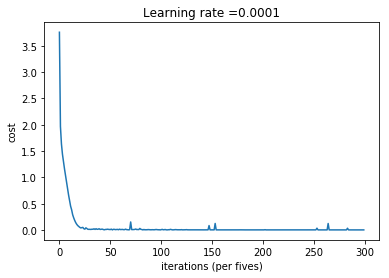

Parameters have been trained!
Train Accuracy: 0.99975
Test Accuracy: 0.82738096


In [106]:
parameters = model(X_train, Y_train, X_test, Y_test)